In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

/notebooks/fastai/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import glob

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [8]:
cuda.set_device(7)

In [9]:
dataset_path = '../dataset/kaggle/fruits-360/'
train_path = dataset_path + '/train'
val_path = dataset_path + '/test'

In [10]:
def get_nrof_images_of_classes(path):
    dic = {}
    class_names = [os.path.basename(x) for x in glob.glob(path + '/*')]
    for class_name in class_names:
        dic[class_name] = len(glob.glob(path + '/' + class_name + '/*'))
    return dic

In [11]:
def plot_nrof_images_histogram(path):
    nrof_images_of_train_classes = get_nrof_images_of_classes(path)
    values = nrof_images_of_train_classes.values()
    f = plt.figure(figsize=(20,20))
    plt.bar(range(len(values)), values)
    plt.show()

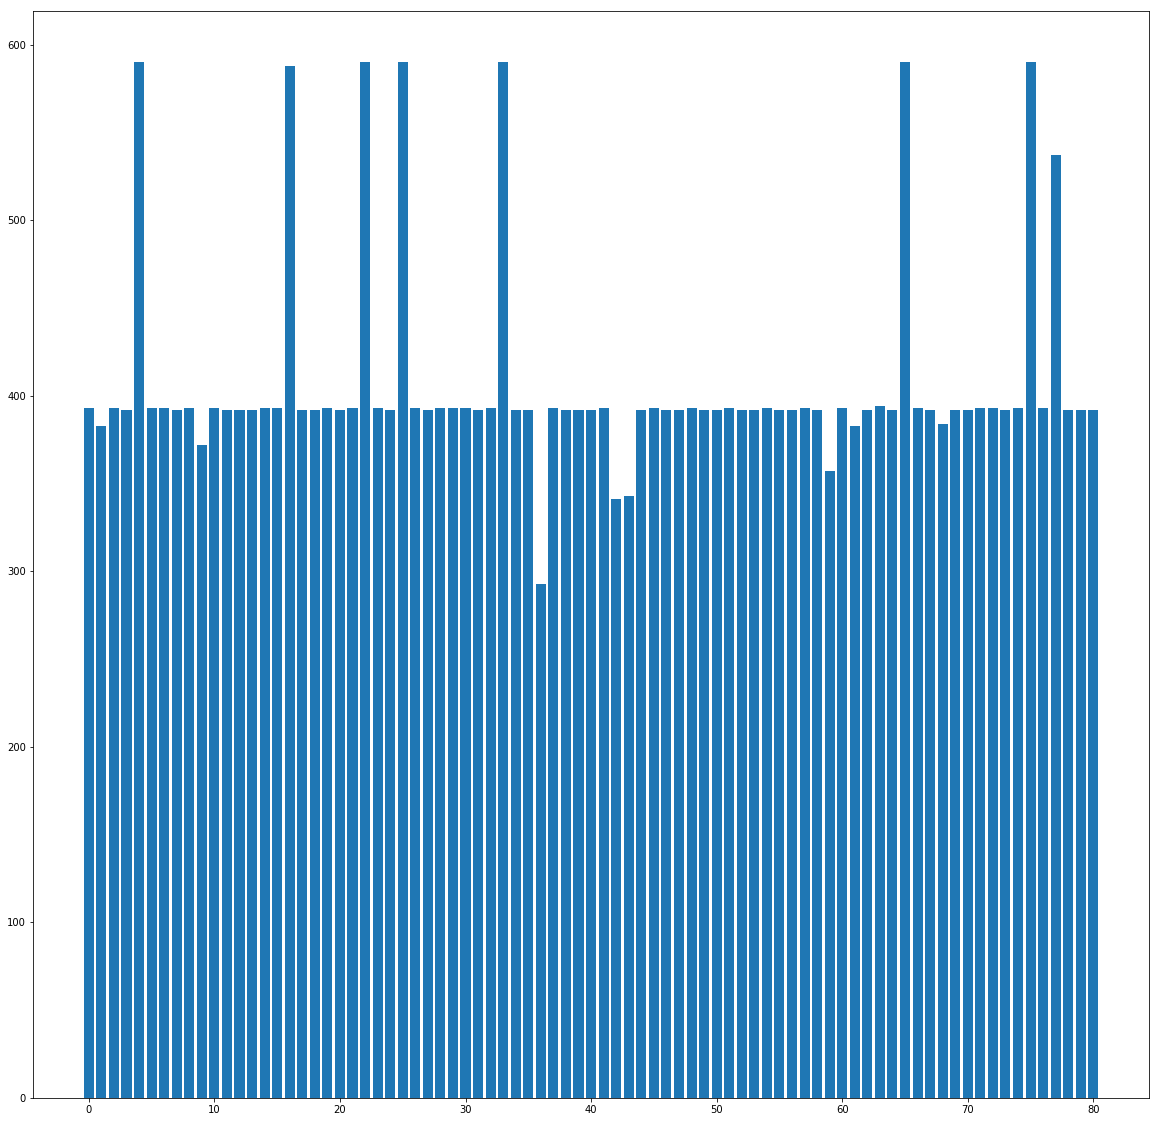

In [12]:
plot_nrof_images_histogram(train_path)

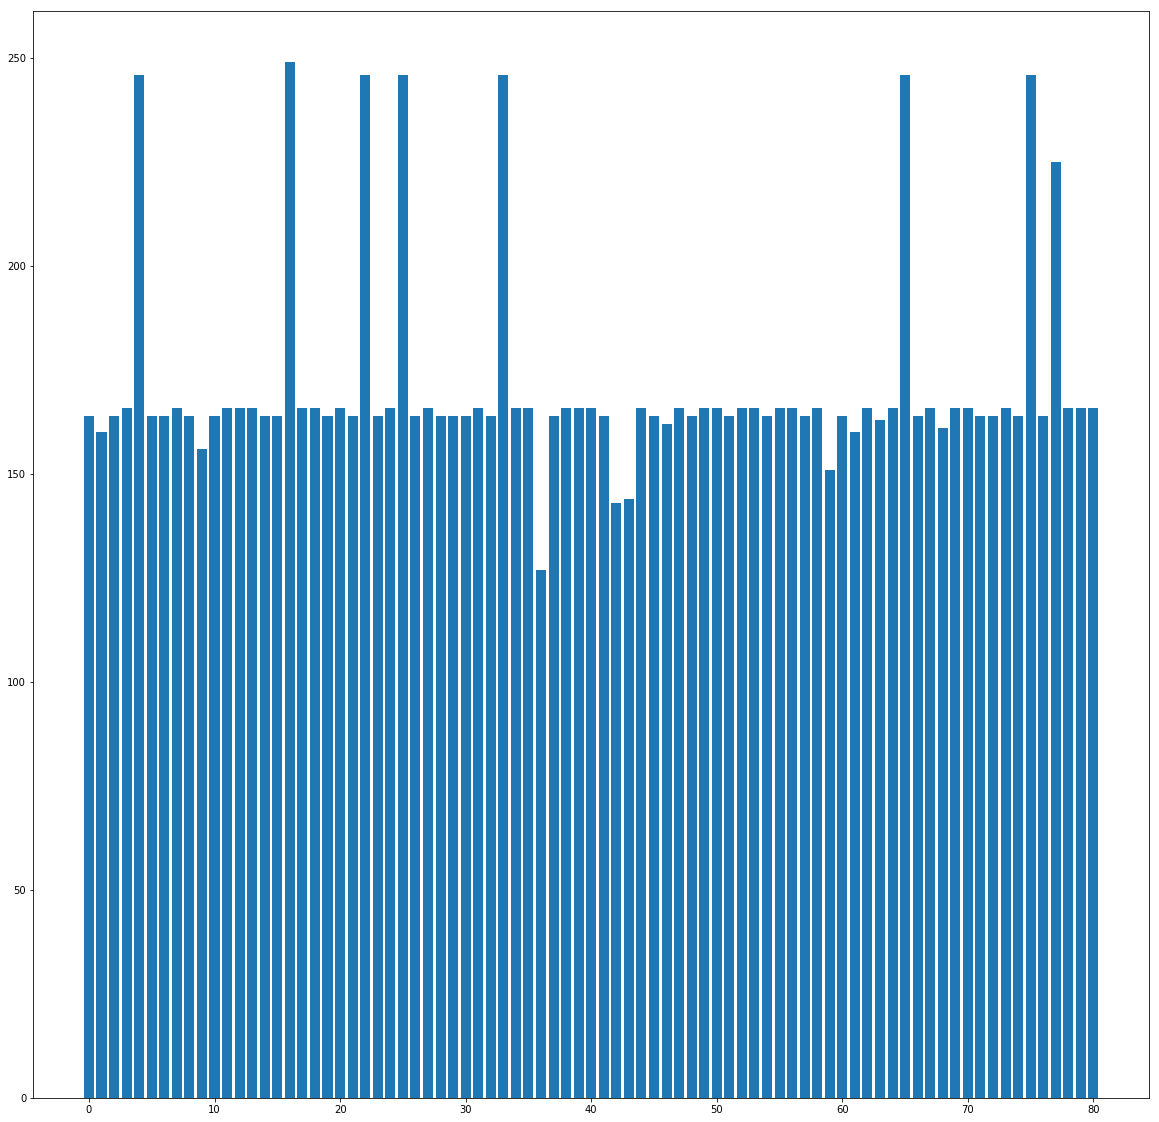

In [13]:
plot_nrof_images_histogram(val_path)

In [14]:
input_size = 224

In [15]:
model = resnet50

We use transform side on plus transform up side down, because the fruit can be put in any direction, not like dogs and cats data.

In [16]:
tfms = tfms_from_model(model, input_size, aug_tfms=transforms_side_on + [RandomDihedral()])

In [17]:
data = ImageClassifierData.from_paths(path=dataset_path, bs=64, tfms=tfms, val_name='test')

# Set precompute on and fit the model for the first time

So what is <b>precompute = True</b>?<br>
When precompute is on, the library compute all the activations from the beginning and save the computation for the penultimate layer. Because of this, when we train the last layer, we just have to feed the precomputation to the last layer and we don't have to compute forward and backward through all layers of our neural network all the time. That saves a lot of time!
<br><br>
<b> Augmentation will not work </b> if precompute = True.
<br>
This is because precompute require the specific input to compute exactly the activation of that input. Augmentation process will produce a lot of random input and that's why they will be disabled when we set precompute = True.

In [18]:
learner = ConvLearner.pretrained(f=model, data=data, precompute=True)

# Finding learning rate

Learning rate is the most important hyperparameter of our model. First, we have to find the learning rate.

In [19]:
lrs = learner.lr_find()

 83%|████████▎ | 428/517 [00:04<00:00, 89.09it/s, loss=1.23]  


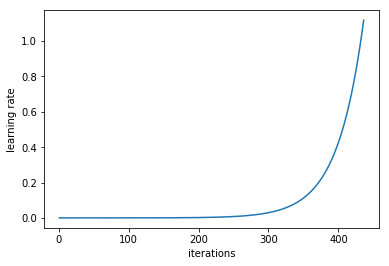

In [20]:
learner.sched.plot_lr()

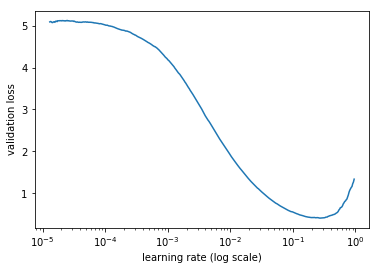

In [21]:
learner.sched.plot()

In [22]:
learner.fit(lrs=0.04, n_cycle=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.031786   0.061239   0.986524  



[0.06123859060929333, 0.9865244649419903]

In [23]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
acc

0.9865244649419903

In [24]:
def plots(ims, figsize=(20,20), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    num_in_figure = len(ims) // rows * rows
    num_row = rows
    if num_in_figure < len(ims):
        num_row += 1
    for i in range(num_in_figure):
        sp = f.add_subplot(num_row, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

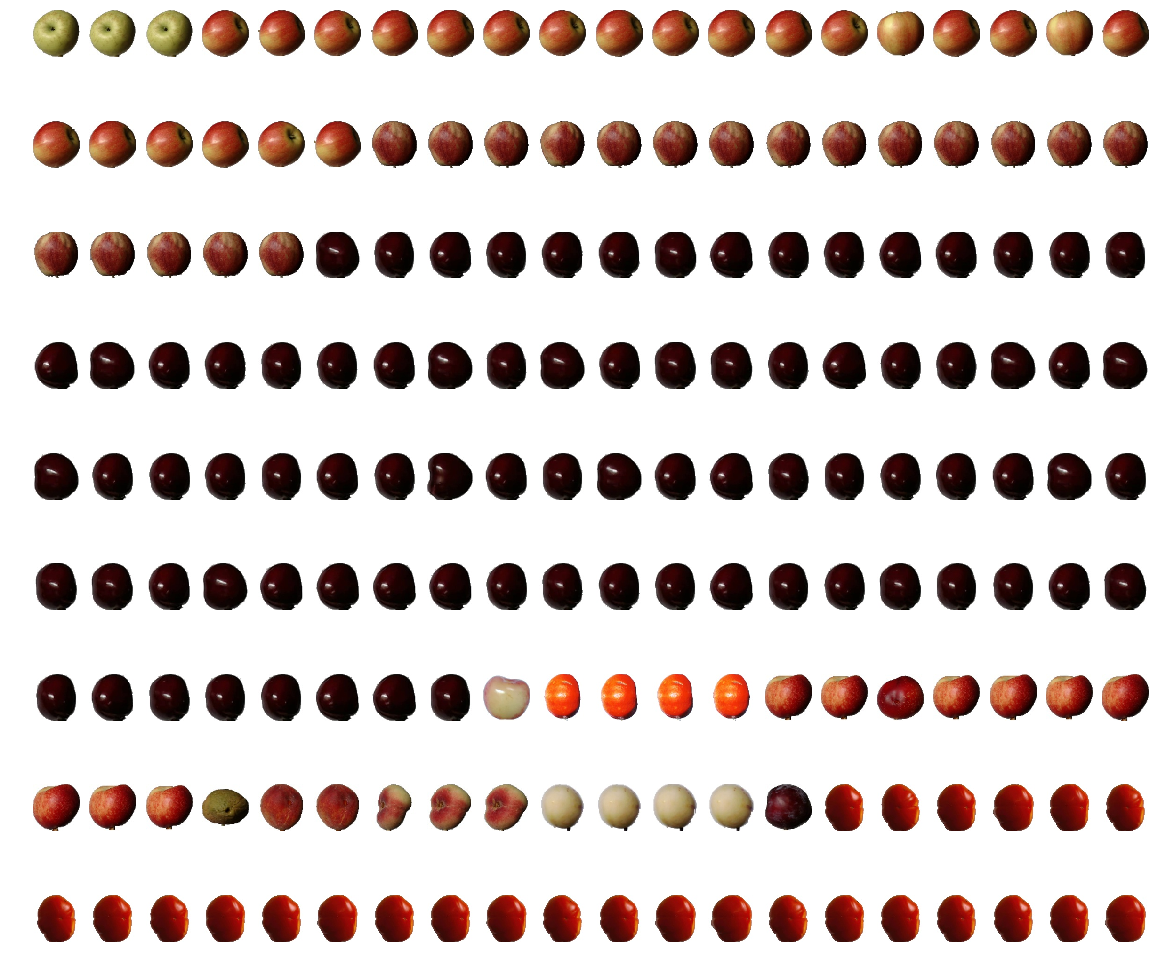

In [25]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=9)

In [26]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  527 : Actual class:  Apple Golden 3 - Predict class:  Apple Granny Smith
Test image  579 : Actual class:  Apple Golden 3 - Predict class:  Apple Granny Smith
Test image  625 : Actual class:  Apple Golden 3 - Predict class:  Apple Granny Smith
Test image  986 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1001 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1009 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1017 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1022 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1024 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1035 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1053 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1057 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1064 : Actual class:  A

# Turn off precompute and train the model with augmentation data

View some augmentation data to check if they're suitable.

In [27]:
def get_augs():
    data = ImageClassifierData.from_paths(dataset_path, bs=2, tfms=tfms, num_workers=1, val_name='test')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

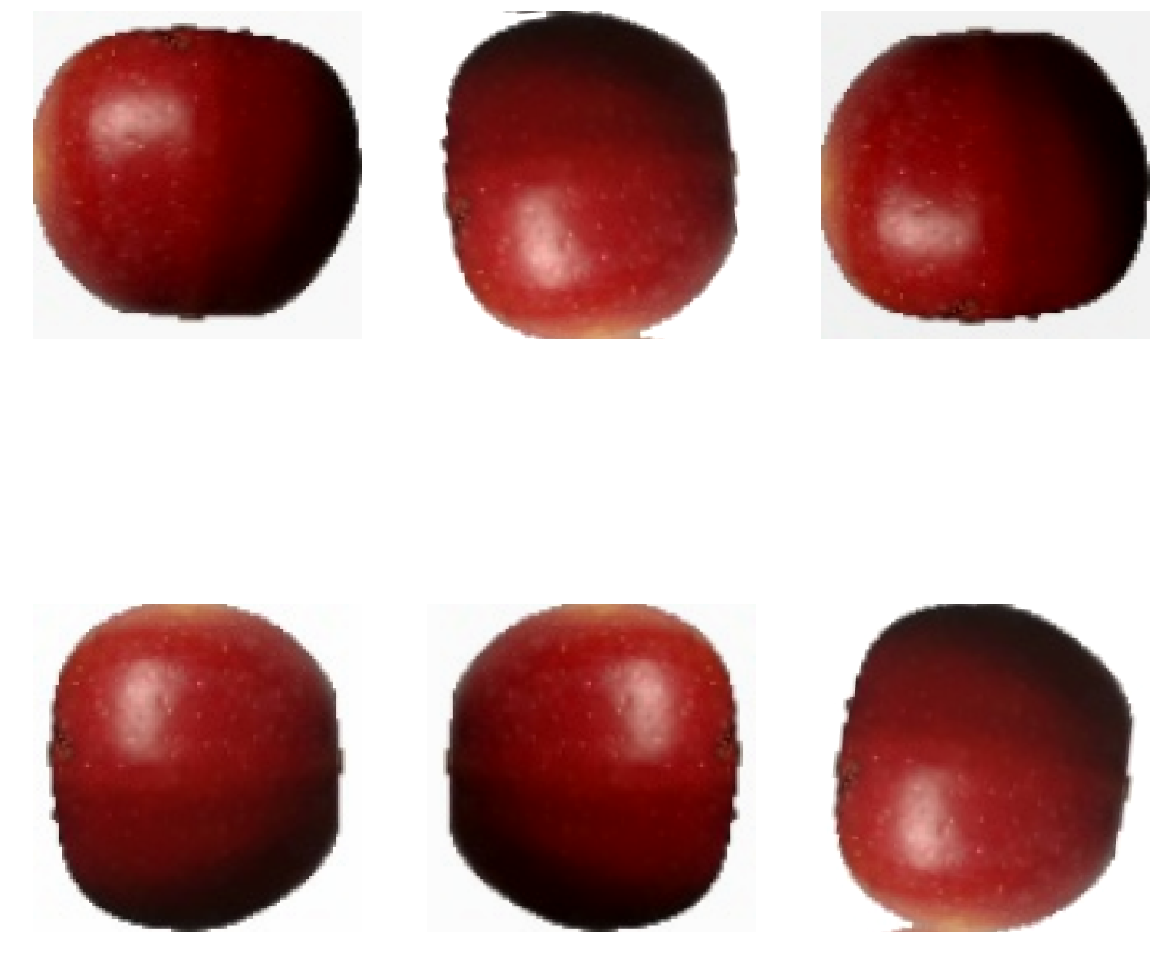

In [28]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

Next we have to turn off precompute so that we can train the model with augmentation data.

In [29]:
learner.precompute = False

In [30]:
learner.fit(lrs=0.04, n_cycle=3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.051406   0.041234   0.987822  
    1      0.033894   0.035761   0.987822                     
    2      0.027753   0.036705   0.987389                     



[0.03670501509691612, 0.9873892051596166]

In [32]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
acc

0.9873892051596166

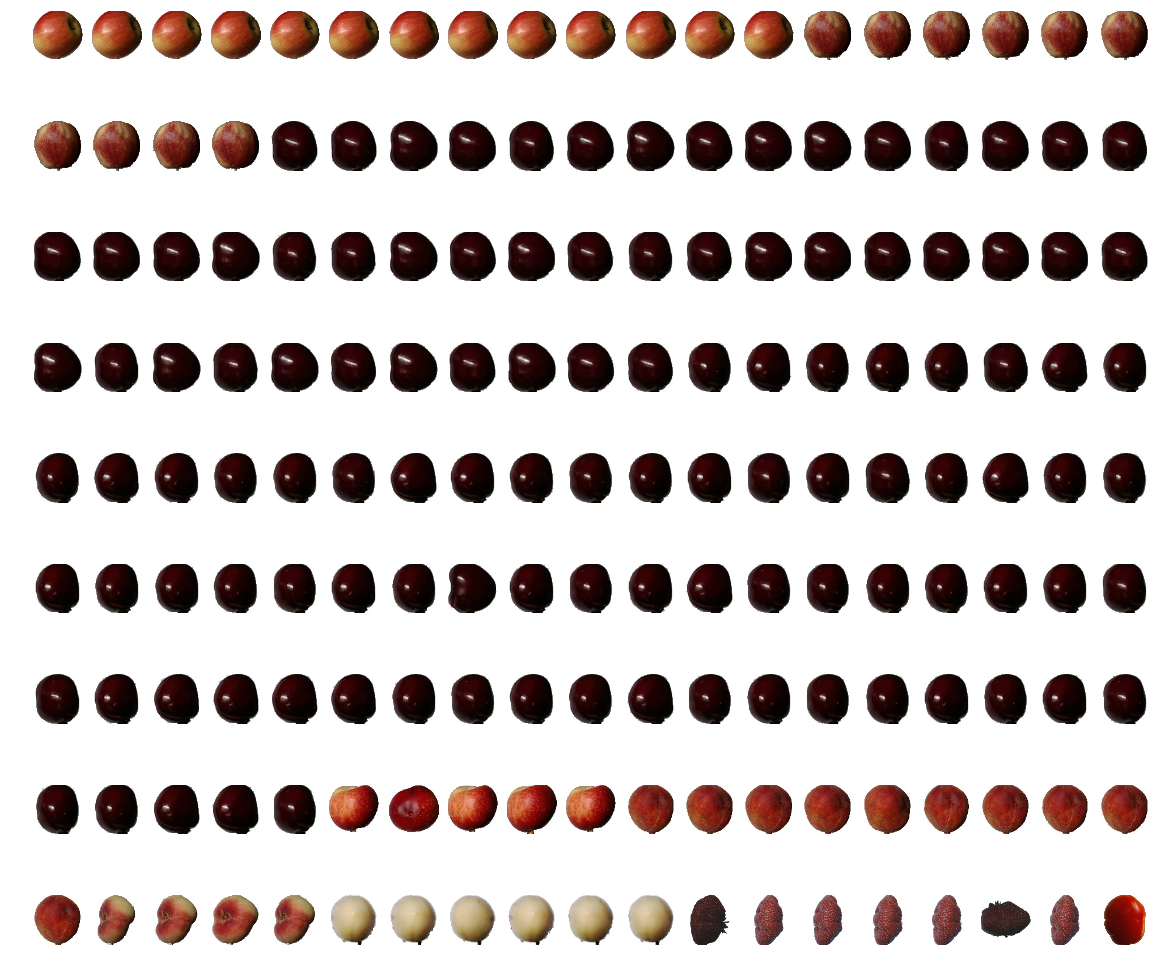

In [33]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=9)

# Unfreeze all the layers and fine tune the model

Next we unfreeze all the layers to fine tune the model. We divide the model into 3 blocks with 3 different learning rates. We set the lower learning rate for earlier blocks cause we don't want to destroy the weights trained by imagenet (which is the dataset with very large number of images). We just want to change it slightly so they can fit better with our data.

In [34]:
learner.unfreeze()

In [35]:
lr = 0.04
lrs=np.array([lr/500, lr/50, lr])

In [36]:
learner.fit(lrs=lrs, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.033246   0.023907   0.989623  
    1      0.034452   0.02385    0.9902                       
    2      0.021151   0.024252   0.989335                     
    3      0.015466   0.02015    0.990632                     
    4      0.023543   0.02202    0.989407                     
    5      0.012539   0.02229    0.989263                     



[0.022290318106891943, 0.9892628089644736]

In [37]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9892628089644736

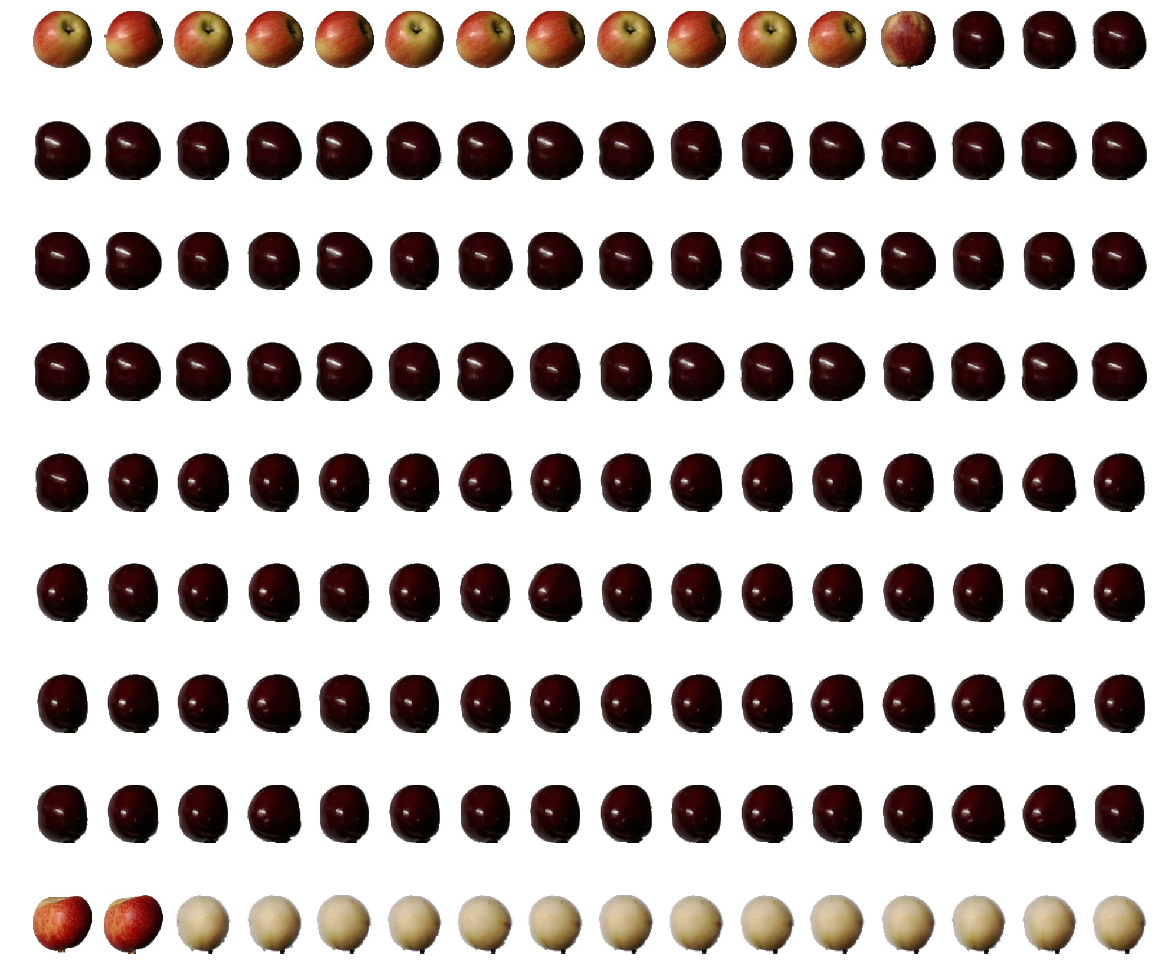

In [38]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=9)

In [39]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  1005 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1013 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1015 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1024 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1053 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1058 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1061 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1064 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1086 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1129 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1132 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1138 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  1219 : Actual class:  Apple Red 3 - Pred

In [40]:
import matplotlib.image as mpimg

In [41]:
def plot_actual_image_vs_predict_class(image_num):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(data.val_ds.get_x(image_num))
    axes[0].set(title='Actual image')
    predict_class_sample_image = random.choice(glob.glob(train_path + '/' + data.classes[preds[image_num]] + '/*'))
    img = mpimg.imread(predict_class_sample_image)
    axes[1].imshow(img)
    axes[1].set(title='Predict class')
    plt.show()

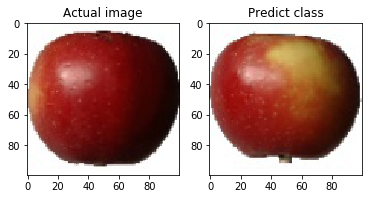

In [42]:
i = np.random.randint(len(false_classify))
plot_actual_image_vs_predict_class(i)

 45%|████▍     | 232/517 [01:36<01:54,  2.48it/s, loss=0.0366]

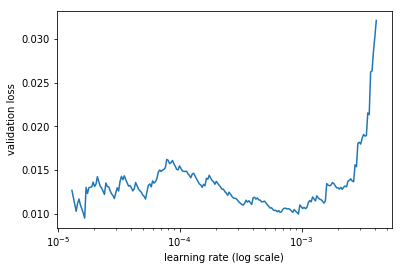

In [43]:
learner.lr_find()
learner.sched.plot()

In [44]:
learner.fit(lrs=0.0005, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.014929   0.023934   0.988975  
    1      0.037037   0.022498   0.989911                      
    2      0.015485   0.026213   0.990055                     
    3      0.012607   0.023107   0.989263                     
    4      0.014334   0.022035   0.990055                      
    5      0.009438   0.020433   0.9902                        


[0.02043272602443962, 0.9901996108669021]

In [45]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9901996108669021

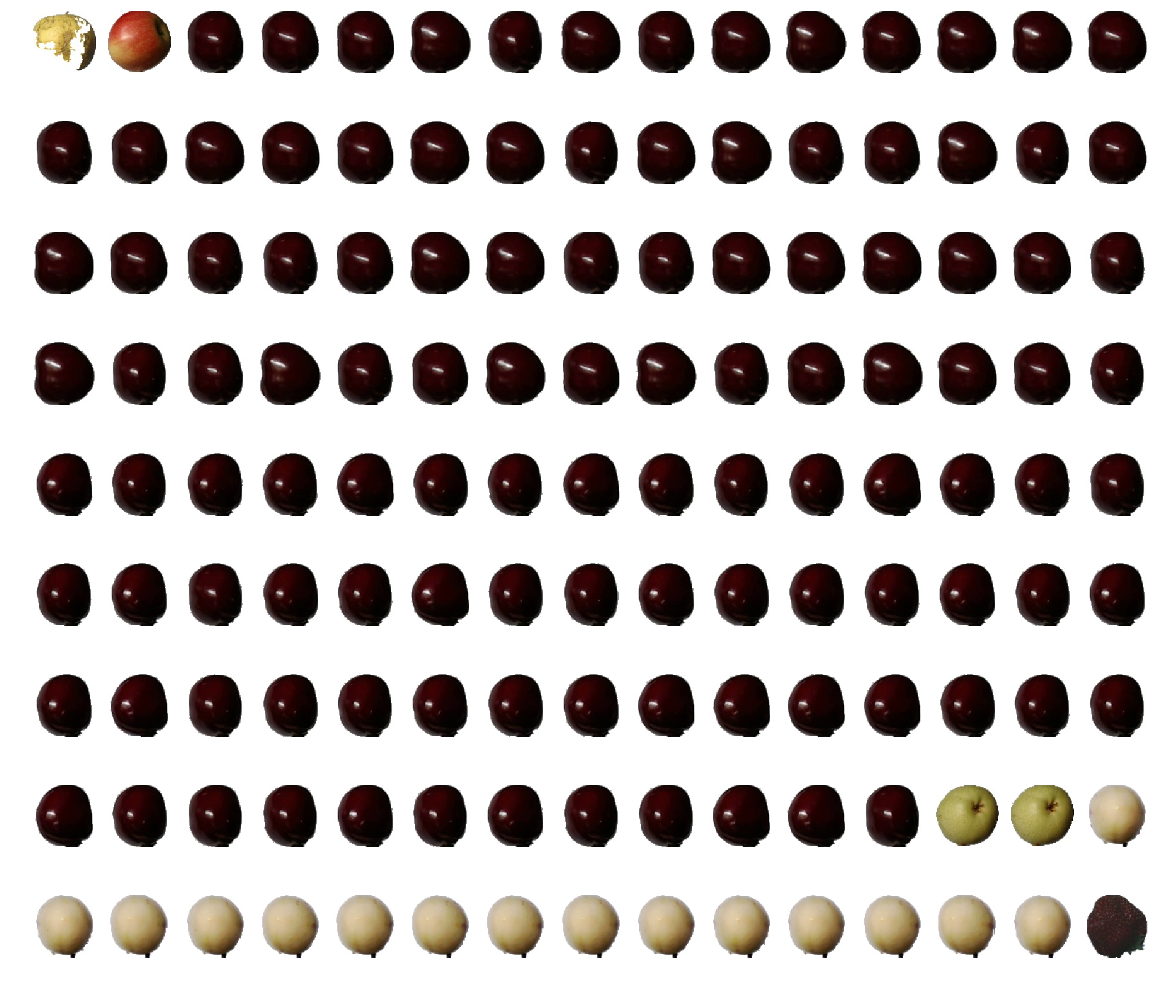

In [46]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=9)

In [47]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  296 : Actual class:  Apple Golden 1 - Predict class:  Pineapple Mini
Test image  1053 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  3089 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3098 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3099 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3101 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3104 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3108 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3112 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3113 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3114 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3117 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3118 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3119 : Actual class:  Cherry 1 - Predict class:  Cherry 2


# Using TTA to predict

In [48]:
preds_tta, y = learner.TTA()

In [49]:
preds = np.argmax(np.mean(preds_tta, 0), axis=1)

We can see slightly better result here

In [50]:
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9904878576061108

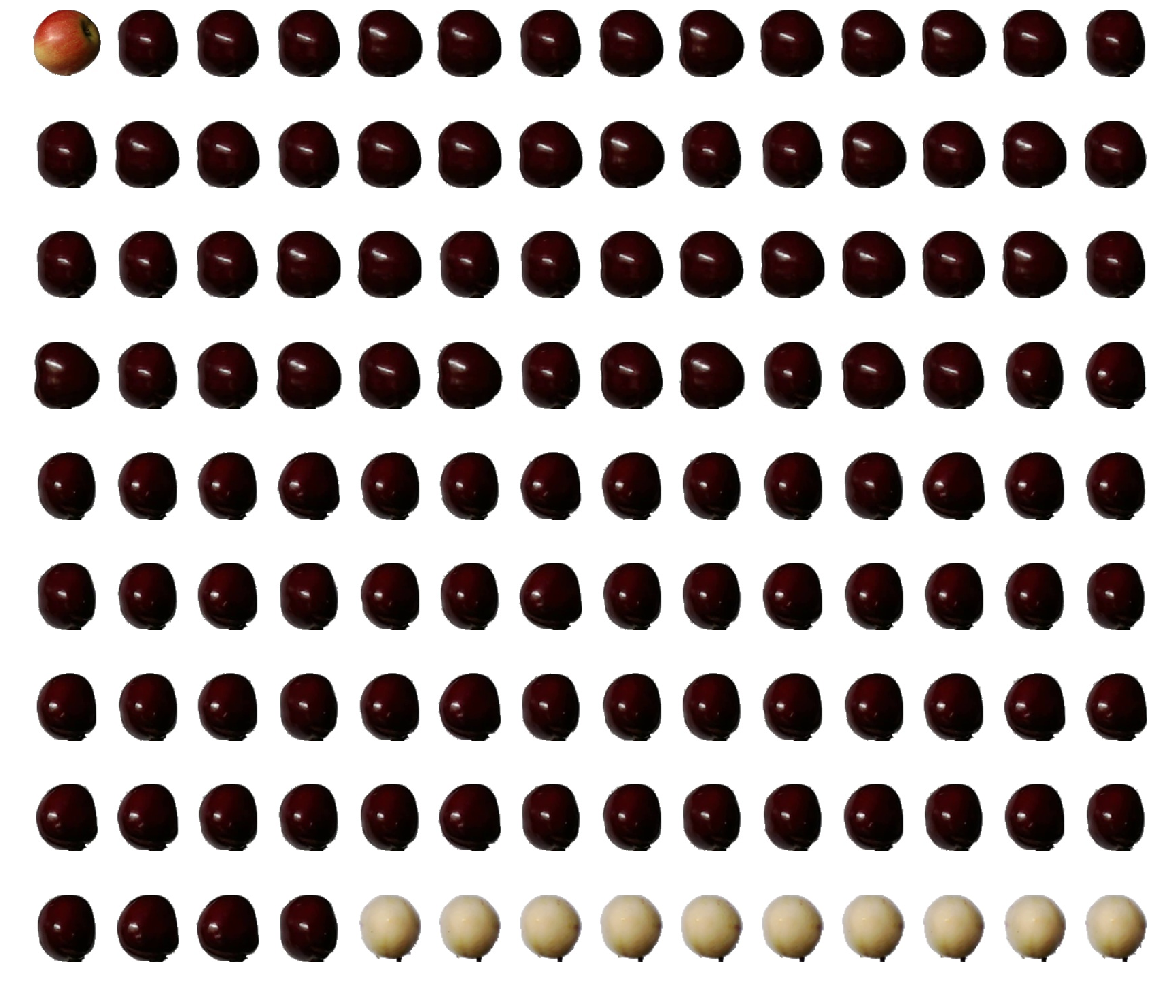

In [51]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=9)

In [52]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  1024 : Actual class:  Apple Red 2 - Predict class:  Apple Braeburn
Test image  3089 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3098 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3099 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3101 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3108 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3112 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3113 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3114 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3117 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3118 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3119 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3123 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image  3125 : Actual class:  Cherry 1 - Predict class:  Cherry 2
Test image 

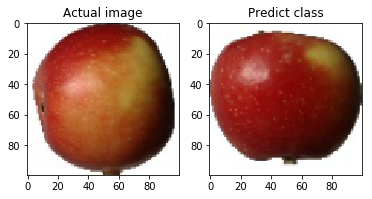

In [53]:
i = np.random.randint(len(false_classify))
plot_actual_image_vs_predict_class(i)

# Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [55]:
?plot_confusion_matrix

[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0 249]]


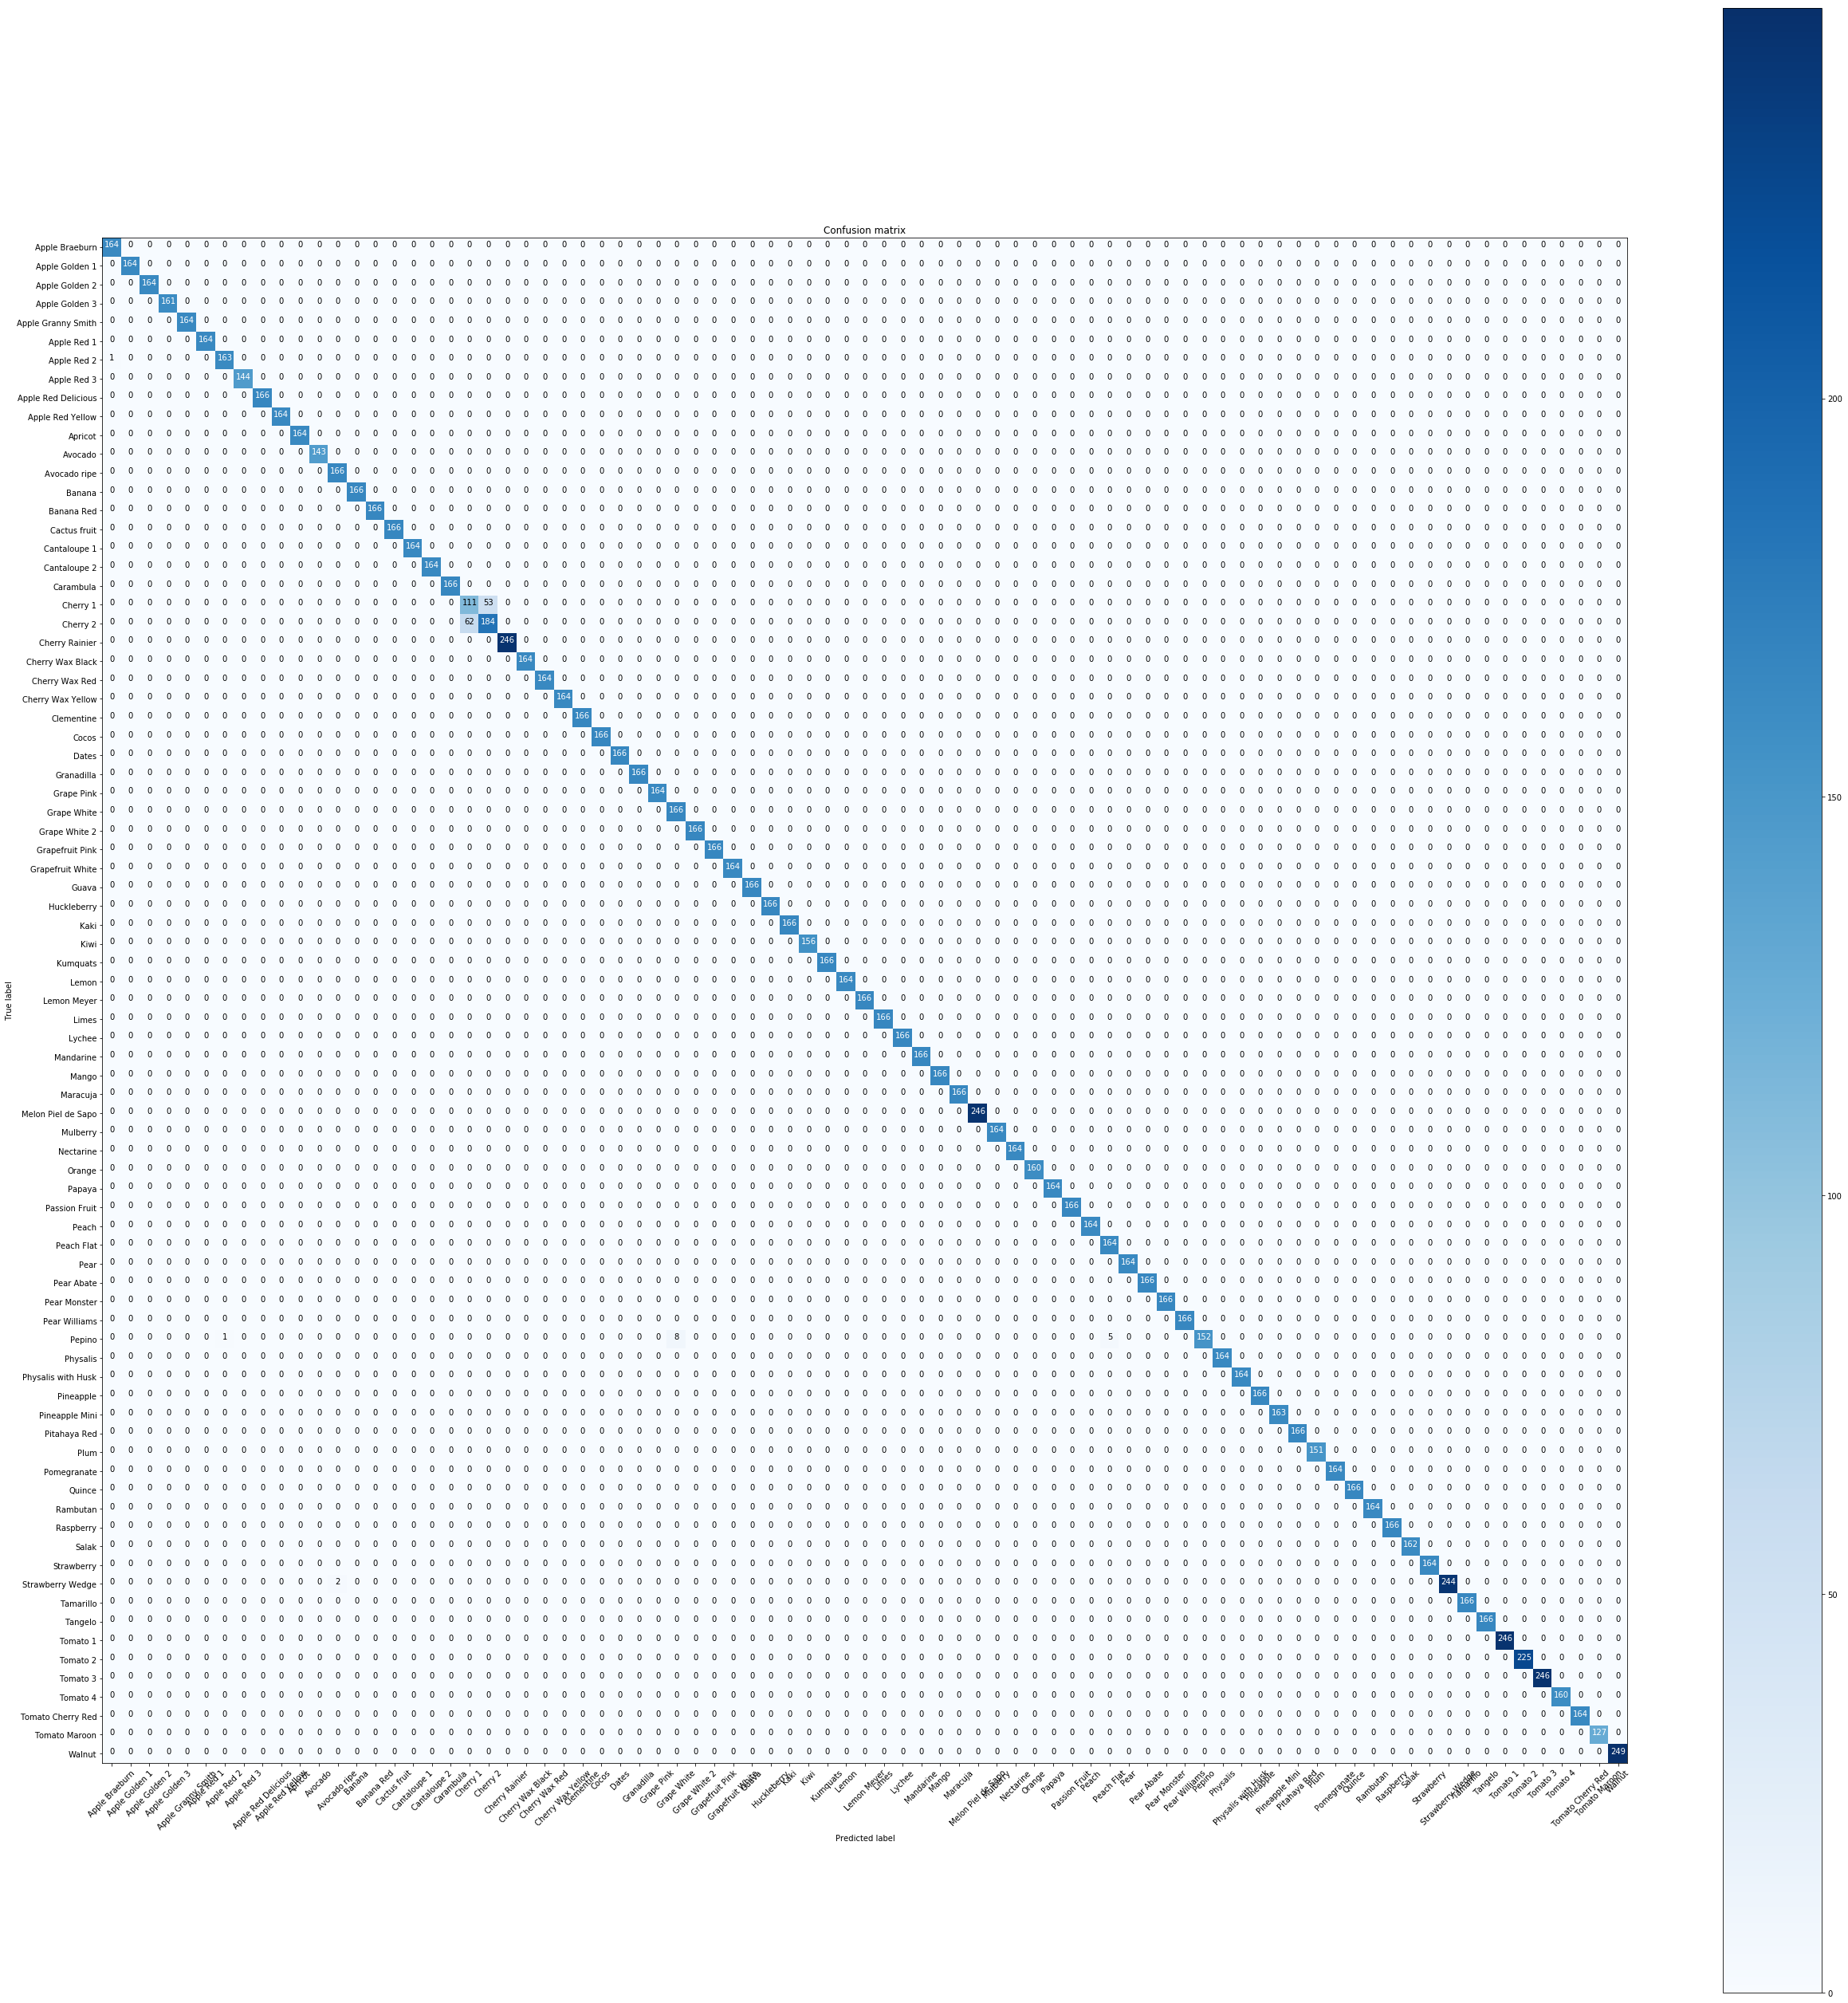

In [56]:
plot_confusion_matrix(cm, data.classes, figsize=(35,35))